In [1]:
import pandas as pd
from tensorflow.keras import layers, models, regularizers
import numpy as np
from sklearn.model_selection import train_test_split, KFold
import pickle
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import backend as K
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
import tensorflow as tf

from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.optimizers import Adam

In [2]:
path_csvs = "D:/mestrado/notebooks/dados/features_csv"
cols_to_scale = ['RMSE', 'ZCR', 'COEF_1', 'COEF_2', 'COEF_3', 'COEF_4', 'COEF_5', 'COEF_6', 'COEF_7', 'COEF_8', 'COEF_9', 'COEF_10', 'COEF_11', 'COEF_12', 'COEF_13', 'COEF_14', 'COEF_15', 'COEF_16', 'COEF_17', 'COEF_18', 'COEF_19', 'COEF_20']

In [3]:
df_masculino_completo_normalizado = pd.read_csv("D:/mestrado/notebooks/dados/features_csv/masculino_completo_normalizado_balanceado.csv", sep=";")


### Criando Tensor

In [4]:
def dataframe_to_tensor(df, num_features):
    grouped = df.groupby("Audio")
    # Cria uma lista de arrays, um para cada áudio
    tensors = [group.iloc[:, :num_features].values for _, group in grouped]
    return np.array(tensors)  # Converte para um tensor 3D

In [5]:
# Função para padronizar as sequências (com padding ou truncamento)
def standardize_frames(sequences, max_frames):
    standardized_sequences = []
    for seq in sequences:
        if len(seq) < max_frames:
            # Padding: Adiciona zeros ao final da sequência
            padded_seq = np.pad(seq, ((0, max_frames - len(seq)), (0, 0)), mode='constant')
            standardized_sequences.append(padded_seq)
        else:
            # Truncamento: Corta a sequência para o tamanho máximo
            truncated_seq = seq[:max_frames, :]
            standardized_sequences.append(truncated_seq)
    return np.array(standardized_sequences)

In [6]:
grouped = df_masculino_completo_normalizado.groupby("Audio")
df_frames = pd.DataFrame()
df_frames['frames'] = df_masculino_completo_normalizado.groupby("Audio").size()

In [7]:
### Verifica a quantidade de audios por classe

df_masculino_completo_normalizado
contagem = df_masculino_completo_normalizado['Audio'].nunique()
print("Existem ", contagem, "áudios.")

df_distintos = df_masculino_completo_normalizado.drop_duplicates(subset='Audio')
contagem_categoria = df_distintos['Label Multiclasse'].value_counts()
print("Relação de áudios por classe:")
print(contagem_categoria)

assert len(set(contagem_categoria)) == 1

Existem  1250 áudios.
Relação de áudios por classe:
Label Multiclasse
disfonia     250
paralisia    250
laringite    250
polipo       250
saudavel     250
Name: count, dtype: int64


In [8]:
df_frames.head()
print(df_frames['frames'].sum())
numero_max_frames = int(df_frames['frames'].mean())
print('numero_max_frames ', numero_max_frames)

124694
numero_max_frames  99


In [9]:
def extract_y(df):
    num_features = 23  # RMS (1) + ZCR (1) + 20 MFCCs
    grouped = df.groupby("Audio")

    # Converta cada áudio para uma matriz (frames x features)
    sequences = [group.iloc[:, :num_features].values for _, group in grouped]

    # Padronize os frames
    max_frames = numero_max_frames  # Defina o número fixo de frames
    tensor = standardize_frames(sequences, max_frames)

    print("Shape do tensor:", tensor.shape)  # Deve ser (num_audios, max_frames, num_features)

    y = []
    for s in sequences:
        for element in s[0]:
            if isinstance(element, str): 
                if 'saudavel' in element:
                        y.append(0)
                elif 'disfonia' in element:
                     y.append(1)
                elif 'laringite' in element:
                     y.append(2)
                elif 'paralisia' in element:
                     y.append(3)
                elif 'polipo' in element:
                     y.append(4)
                else:
                    y.append(None)
                break
            
    print('Len(y)')
    print(len(y))

    none_indexes = [i for i, val in enumerate(y) if val == None]
    # print result
    print("The None indices list is : " + str(none_indexes))
    assert len(none_indexes) == 0

    # Transformação para one-hot
    one_hot_labels = tf.keras.utils.to_categorical(y, num_classes=5)
    print(one_hot_labels)

    return one_hot_labels


In [10]:
def extract_tensor_x(df):
    num_features = 22  # RMS (1) + ZCR (1) + 20 MFCCs
    # Agrupe o DataFrame por áudio
    grouped = df.groupby("Audio")

    # Converta cada áudio para uma matriz (frames x features)
    sequences = [group.iloc[:, :num_features].values for _, group in grouped]

    # Padronize os frames
    max_frames = numero_max_frames  # Defina o número fixo de frames
    tensor = standardize_frames(sequences, max_frames)

    print("Shape do tensor:", tensor.shape)  # Deve ser (num_audios, max_frames, num_features)
    return tensor


### Criando a Rede Neural

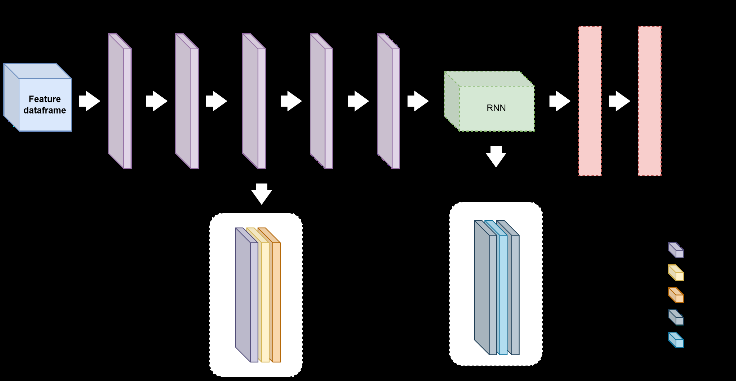

In [11]:
def generate_model_grid_search(learning_rate=0.001, dropout_rate=0.2, lstm_units=128):


    print("Iniciando o modelo com os seguintes parâmetros: Learning Rate - ", learning_rate, " Dropout - ", dropout_rate, " LSTM Units - ", lstm_units)

    # Dimensão das features (exemplo: 20 MFCCs + RMS + ZCR -> 22 features por timestep)
    input_shape = (None, 22)  # None -> Sequência variável, 22 -> Features por timestep

    # Regularização L2 (lambda = 0.01)
    l2_reg = regularizers.L2(0.005)

    # Entrada
    inputs = layers.Input(shape=input_shape)

    # 5 Blocos CNN
    x = inputs
    for _ in range(6):
        x = layers.Conv1D(128, kernel_size=3, padding="same", activation="relu", kernel_regularizer=l2_reg)(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling1D(pool_size=2)(x)
        x = layers.Dropout(dropout_rate)(x)  # Dropout adicional
        # print("Após bloco CNN:", x.shape)

    # print(x.shape)

    # LSTM com regularização L2
    x = layers.LSTM(lstm_units, return_sequences=True, kernel_regularizer=l2_reg)(x)
    # print("Após LSTM (return_sequences=True):", x.shape)

    # Multi-Head Attention
    # attention = layers.MultiHeadAttention(num_heads=4, key_dim=64)(x, x)  # 4 cabeças de atenção
    # x = layers.Add()([x, attention])  # Resíduo para estabilizar treinamento
    #print("Após Multi-Head Attention:", x.shape)

    # Atenção Personalizada
    query = layers.Dense(256, activation="tanh")(x)  # Projeta a sequência
    key = layers.Dense(256, activation="tanh")(x)    # Projeta a sequência
    score = layers.Dot(axes=[2, 2])([query, key])    # Produto escalar
    attention_weights = layers.Softmax()(score)     # Pesos normalizados
    context = layers.Dot(axes=[2, 1])([attention_weights, x])  # Combina pesos com sequência

    # Skip connection
    x = layers.Add()([x, context])


    # LSTM final para resumir a sequência
    x = layers.LSTM(lstm_units, kernel_regularizer=l2_reg)(x)
    # print("Após LSTM final:", x.shape)

    # Camadas densas para classificação com regularização e Dropout
    x = layers.Dense(128, activation="relu", kernel_regularizer=l2_reg)(x)
    x = layers.Dropout(dropout_rate)(x)
    # print("Após Dense:", x.shape)

    # Camada de saída multiclasse
    num_classes = 5
    outputs = layers.Dense(num_classes, activation="softmax", kernel_regularizer=l2_reg)(x)
    # print("Saída:", outputs.shape)

    # Construção do modelo
    model = models.Model(inputs, outputs)

    # Compilação
    #optimizer = Adam(learning_rate=1e-3)  # Taxa de aprendizado inicial
    # Learning Rate default do Adam = 0.001
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss="categorical_crossentropy", metrics=["accuracy", "categorical_accuracy",  "precision", "recall"])
    return model


In [12]:
# dividindo tensor entre treino, validação e teste
X = extract_tensor_x(df_masculino_completo_normalizado)
y = extract_y(df_masculino_completo_normalizado)

assert len(y) == 1250
assert X.shape[0] == len(y)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("Shape dos conjuntos:")
print(f"Treino: {X_train.shape}, Validação: {X_val.shape}, Teste: {X_test.shape}")


Shape do tensor: (1250, 99, 22)
Shape do tensor: (1250, 99, 23)
Len(y)
1250
The None indices list is : []
[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]
Shape dos conjuntos:
Treino: (875, 99, 22), Validação: (187, 99, 22), Teste: (188, 99, 22)


In [13]:
# Parâmetros para testar
# O KerasClassifier passa automaticamente batch_size e epochs para o método .fit() quando ajusta o modelo.
#params_grid = {
#    'batch_size': [16, 32, 64],
#    'epochs': [10, 20, 30],
#    'model__learning_rate': [0.01, 0.001, 0.0005],
#    'model__dropout_rate': [0.2, 0.3, 0.4],
#    'model__lstm_units': [128, 256]
#}

params_grid = {
    'batch_size': [32, 64],
    'epochs': [20],
    'model__learning_rate': [0.001, 0.0005],
    'model__dropout_rate': [0.2],
    'model__lstm_units': [128, 256]
}

# Criação do modelo
model = KerasClassifier(build_fn=generate_model_grid_search, verbose=1)

# GridSearchCV
grid = GridSearchCV(
    estimator=model,
    param_grid=params_grid,
    scoring="accuracy",
    cv=3  # 3-fold cross-validation
)

# Ajuste dos dados
grid_result = grid.fit(X_train, y_train)


c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Iniciando o modelo com os seguintes parâmetros: Learning Rate -  0.001  Dropout -  0.2  LSTM Units -  128
Epoch 1/20


c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.3178 - categorical_accuracy: 0.3178 - loss: 7.2509 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5847 - categorical_accuracy: 0.5847 - loss: 5.4341 - precision: 0.9000 - recall: 0.1008    
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6370 - categorical_accuracy: 0.6370 - loss: 4.0037 - precision: 0.8870 - recall: 0.4023
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7518 - categorical_accuracy: 0.7518 - loss: 3.2394 - precision: 0.8882 - recall: 0.5380
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7595 - categorical_accuracy: 0.7595 - loss: 2.8675 - precision: 0.8326 - recall: 0.6480
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8326 - categorical_accuracy: 0.8326 - loss: 2.4412 - precision: 0.8840 - recall: 0.7869
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8681 - categoric

c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


 1/10 ━━━━━━━━━━━━━━━━━━━━ 2s 321ms/step

c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
Iniciando o modelo com os seguintes parâmetros: Learning Rate -  0.001  Dropout -  0.2  LSTM Units -  128
Epoch 1/20


c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.3213 - categorical_accuracy: 0.3213 - loss: 7.2635 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5762 - categorical_accuracy: 0.5762 - loss: 5.3370 - precision: 0.8676 - recall: 0.1226    
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6898 - categorical_accuracy: 0.6898 - loss: 4.0449 - precision: 0.9138 - recall: 0.4350
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7814 - categorical_accuracy: 0.7814 - loss: 3.3568 - precision: 0.8519 - recall: 0.7157
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8607 - categorical_accuracy: 0.8607 - loss: 2.8823 - precision: 0.8886 - recall: 0.7971
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8688 - categorical_accuracy: 0.8688 - loss: 2.5957 - precision: 0.9053 - recall: 0.8322
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8741 - categoric

c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


 1/10 ━━━━━━━━━━━━━━━━━━━━ 2s 324ms/step

c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
Iniciando o modelo com os seguintes parâmetros: Learning Rate -  0.001  Dropout -  0.2  LSTM Units -  128
Epoch 1/20


c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.3189 - categorical_accuracy: 0.3189 - loss: 7.2867 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5265 - categorical_accuracy: 0.5265 - loss: 5.4729 - precision: 0.9067 - recall: 0.1555    
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6667 - categorical_accuracy: 0.6667 - loss: 4.1339 - precision: 0.8780 - recall: 0.4129
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7237 - categorical_accuracy: 0.7237 - loss: 3.5251 - precision: 0.8206 - recall: 0.6349
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8227 - categorical_accuracy: 0.8227 - loss: 3.0210 - precision: 0.8786 - recall: 0.7418
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8725 - categorical_accuracy: 0.8725 - loss: 2.7188 - precision: 0.8858 - recall: 0.8368
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8762 - categoric

c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


 1/10 ━━━━━━━━━━━━━━━━━━━━ 2s 333ms/step

c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step
Iniciando o modelo com os seguintes parâmetros: Learning Rate -  0.001  Dropout -  0.2  LSTM Units -  256
Epoch 1/20


c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.3090 - categorical_accuracy: 0.3090 - loss: 8.3314 - precision: 0.1500 - recall: 0.0010       
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6446 - categorical_accuracy: 0.6446 - loss: 5.6005 - precision: 0.9238 - recall: 0.2751
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7556 - categorical_accuracy: 0.7556 - loss: 4.1402 - precision: 0.8278 - recall: 0.6004
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8060 - categorical_accuracy: 0.8060 - loss: 3.4645 - precision: 0.8470 - recall: 0.7483
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8485 - categorical_accuracy: 0.8485 - loss: 2.9989 - precision: 0.8846 - recall: 0.8030
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8751 - categorical_accuracy: 0.8751 - loss: 2.6993 - precision: 0.9001 - recall: 0.8238
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9028 - categorical_ac

c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


 1/10 ━━━━━━━━━━━━━━━━━━━━ 2s 320ms/step

c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
Iniciando o modelo com os seguintes parâmetros: Learning Rate -  0.001  Dropout -  0.2  LSTM Units -  256
Epoch 1/20


c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.3242 - categorical_accuracy: 0.3242 - loss: 8.3162 - precision: 0.2500 - recall: 0.0047       
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6209 - categorical_accuracy: 0.6209 - loss: 5.6061 - precision: 0.9073 - recall: 0.2833
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8041 - categorical_accuracy: 0.8041 - loss: 4.0405 - precision: 0.8785 - recall: 0.6886
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8411 - categorical_accuracy: 0.8411 - loss: 3.4011 - precision: 0.8735 - recall: 0.7962
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8716 - categorical_accuracy: 0.8716 - loss: 2.9195 - precision: 0.8940 - recall: 0.8306
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8953 - categorical_accuracy: 0.8953 - loss: 2.6430 - precision: 0.9054 - recall: 0.8684
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8831 - categorical_ac

c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


 1/10 ━━━━━━━━━━━━━━━━━━━━ 2s 309ms/step

c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
Iniciando o modelo com os seguintes parâmetros: Learning Rate -  0.001  Dropout -  0.2  LSTM Units -  256
Epoch 1/20


c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.3450 - categorical_accuracy: 0.3450 - loss: 8.3316 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6341 - categorical_accuracy: 0.6341 - loss: 5.6292 - precision: 0.9042 - recall: 0.2470
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7613 - categorical_accuracy: 0.7613 - loss: 4.1590 - precision: 0.8449 - recall: 0.6683
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8083 - categorical_accuracy: 0.8083 - loss: 3.4939 - precision: 0.8569 - recall: 0.7511
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8878 - categorical_accuracy: 0.8878 - loss: 2.9504 - precision: 0.9266 - recall: 0.8432
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8733 - categorical_accuracy: 0.8733 - loss: 2.7025 - precision: 0.9052 - recall: 0.8499
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8731 - categorical_a

c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
Iniciando o modelo com os seguintes parâmetros: Learning Rate -  0.0005  Dropout -  0.2  LSTM Units -  128
Epoch 1/20


c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.2971 - categorical_accuracy: 0.2971 - loss: 7.5118 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5723 - categorical_accuracy: 0.5723 - loss: 6.5576 - precision: 0.2000 - recall: 8.6691e-04   
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6273 - categorical_accuracy: 0.6273 - loss: 5.5692 - precision: 0.9589 - recall: 0.2080
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6492 - categorical_accuracy: 0.6492 - loss: 4.8264 - precision: 0.8135 - recall: 0.3446
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7102 - categorical_accuracy: 0.7102 - loss: 4.2146 - precision: 0.8723 - recall: 0.5500
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7925 - categorical_accuracy: 0.7925 - loss: 3.7174 - precision: 0.8771 - recall: 0.6778
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8483 - catego

c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


 1/10 ━━━━━━━━━━━━━━━━━━━━ 2s 328ms/step

c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
Iniciando o modelo com os seguintes parâmetros: Learning Rate -  0.0005  Dropout -  0.2  LSTM Units -  128
Epoch 1/20


c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.3049 - categorical_accuracy: 0.3049 - loss: 7.4944 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5355 - categorical_accuracy: 0.5355 - loss: 6.5300 - precision: 0.3000 - recall: 0.0063       
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6272 - categorical_accuracy: 0.6272 - loss: 5.5293 - precision: 0.9959 - recall: 0.2288
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7089 - categorical_accuracy: 0.7089 - loss: 4.7175 - precision: 0.9564 - recall: 0.3639
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7434 - categorical_accuracy: 0.7434 - loss: 4.0965 - precision: 0.9212 - recall: 0.4975
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7579 - categorical_accuracy: 0.7579 - loss: 3.6898 - precision: 0.8750 - recall: 0.6969
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8613 - catego

c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


 1/10 ━━━━━━━━━━━━━━━━━━━━ 2s 313ms/step

c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
Iniciando o modelo com os seguintes parâmetros: Learning Rate -  0.0005  Dropout -  0.2  LSTM Units -  128
Epoch 1/20


c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.3413 - categorical_accuracy: 0.3413 - loss: 7.5073 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5149 - categorical_accuracy: 0.5149 - loss: 6.5326 - precision: 0.2500 - recall: 0.0017       
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5714 - categorical_accuracy: 0.5714 - loss: 5.5171 - precision: 0.9856 - recall: 0.2071
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6017 - categorical_accuracy: 0.6017 - loss: 4.7480 - precision: 0.8621 - recall: 0.3672
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7219 - categorical_accuracy: 0.7219 - loss: 4.0906 - precision: 0.8721 - recall: 0.5943
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7806 - categorical_accuracy: 0.7806 - loss: 3.6245 - precision: 0.8763 - recall: 0.6764
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8063 - catego

c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


 1/10 ━━━━━━━━━━━━━━━━━━━━ 2s 324ms/step

c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
Iniciando o modelo com os seguintes parâmetros: Learning Rate -  0.0005  Dropout -  0.2  LSTM Units -  256
Epoch 1/20


c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.3401 - categorical_accuracy: 0.3401 - loss: 8.6895 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5160 - categorical_accuracy: 0.5160 - loss: 7.1041 - precision: 0.8321 - recall: 0.0706   
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5674 - categorical_accuracy: 0.5674 - loss: 5.7658 - precision: 0.9612 - recall: 0.3089
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7383 - categorical_accuracy: 0.7383 - loss: 4.7952 - precision: 0.8829 - recall: 0.5919
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8096 - categorical_accuracy: 0.8096 - loss: 4.1895 - precision: 0.8860 - recall: 0.7419
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8706 - categorical_accuracy: 0.8706 - loss: 3.7451 - precision: 0.8988 - recall: 0.8168
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8873 - categorica

c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
Iniciando o modelo com os seguintes parâmetros: Learning Rate -  0.0005  Dropout -  0.2  LSTM Units -  256
Epoch 1/20


c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.3298 - categorical_accuracy: 0.3298 - loss: 8.6821 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5684 - categorical_accuracy: 0.5684 - loss: 7.0237 - precision: 0.9893 - recall: 0.1459
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6167 - categorical_accuracy: 0.6167 - loss: 5.7730 - precision: 0.9723 - recall: 0.2502
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7516 - categorical_accuracy: 0.7516 - loss: 4.7948 - precision: 0.8458 - recall: 0.5967
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8082 - categorical_accuracy: 0.8082 - loss: 4.1920 - precision: 0.8689 - recall: 0.7099
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8625 - categorical_accuracy: 0.8625 - loss: 3.7093 - precision: 0.9108 - recall: 0.7931
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8622 - categorical_a

c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


 1/10 ━━━━━━━━━━━━━━━━━━━━ 2s 314ms/step

c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
Iniciando o modelo com os seguintes parâmetros: Learning Rate -  0.0005  Dropout -  0.2  LSTM Units -  256
Epoch 1/20


c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.3268 - categorical_accuracy: 0.3268 - loss: 8.6662 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.4935 - categorical_accuracy: 0.4935 - loss: 7.0284 - precision: 0.8791 - recall: 0.1011   
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6125 - categorical_accuracy: 0.6125 - loss: 5.7432 - precision: 0.8862 - recall: 0.3291
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7688 - categorical_accuracy: 0.7688 - loss: 4.7241 - precision: 0.8912 - recall: 0.6132
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8308 - categorical_accuracy: 0.8308 - loss: 4.0818 - precision: 0.8892 - recall: 0.7380
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8560 - categorical_accuracy: 0.8560 - loss: 3.6913 - precision: 0.9094 - recall: 0.8105
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8914 - categorica

c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


 1/10 ━━━━━━━━━━━━━━━━━━━━ 2s 332ms/step

c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
Iniciando o modelo com os seguintes parâmetros: Learning Rate -  0.001  Dropout -  0.2  LSTM Units -  128
Epoch 1/20


c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.3216 - categorical_accuracy: 0.3216 - loss: 7.4678 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5097 - categorical_accuracy: 0.5097 - loss: 6.3638 - precision: 0.3636 - recall: 0.0021       
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5696 - categorical_accuracy: 0.5696 - loss: 5.2772 - precision: 0.9733 - recall: 0.1966
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6501 - categorical_accuracy: 0.6501 - loss: 4.4292 - precision: 0.8626 - recall: 0.3745
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7600 - categorical_accuracy: 0.7600 - loss: 3.7334 - precision: 0.9306 - recall: 0.5689
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8623 - categorical_accuracy: 0.8623 - loss: 3.2454 - precision: 0.9240 - recall: 0.7366
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8817 - catego

c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (64, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


1/5 ━━━━━━━━━━━━━━━━━━━━ 1s 335ms/step

c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step
Iniciando o modelo com os seguintes parâmetros: Learning Rate -  0.001  Dropout -  0.2  LSTM Units -  128
Epoch 1/20


c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.2923 - categorical_accuracy: 0.2923 - loss: 7.4927 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4816 - categorical_accuracy: 0.4816 - loss: 6.3764 - precision: 0.2727 - recall: 0.0017       
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5943 - categorical_accuracy: 0.5943 - loss: 5.2791 - precision: 0.9895 - recall: 0.2157
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6702 - categorical_accuracy: 0.6702 - loss: 4.4399 - precision: 0.8710 - recall: 0.3057
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7151 - categorical_accuracy: 0.7151 - loss: 3.8106 - precision: 0.8428 - recall: 0.5710
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7704 - categorical_accuracy: 0.7704 - loss: 3.4266 - precision: 0.8416 - recall: 0.6339
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7015 - catego

c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (64, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


1/5 ━━━━━━━━━━━━━━━━━━━━ 1s 331ms/step

c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step
Iniciando o modelo com os seguintes parâmetros: Learning Rate -  0.001  Dropout -  0.2  LSTM Units -  128
Epoch 1/20


c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.2662 - categorical_accuracy: 0.2662 - loss: 7.4763 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5349 - categorical_accuracy: 0.5349 - loss: 6.3726 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5774 - categorical_accuracy: 0.5774 - loss: 5.3108 - precision: 0.7085 - recall: 0.0498     
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6059 - categorical_accuracy: 0.6059 - loss: 4.3726 - precision: 0.8591 - recall: 0.3651
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7466 - categorical_accuracy: 0.7466 - loss: 3.7007 - precision: 0.9015 - recall: 0.6709
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8231 - categorical_accuracy: 0.8231 - loss: 3.3171 - precision: 0.8690 - recall: 0.7207
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8574 - 

c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (64, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


1/5 ━━━━━━━━━━━━━━━━━━━━ 1s 337ms/step

c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step
Iniciando o modelo com os seguintes parâmetros: Learning Rate -  0.001  Dropout -  0.2  LSTM Units -  256
Epoch 1/20


c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.3317 - categorical_accuracy: 0.3317 - loss: 8.6175 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5153 - categorical_accuracy: 0.5153 - loss: 6.7815 - precision: 0.9961 - recall: 0.1263
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5880 - categorical_accuracy: 0.5880 - loss: 5.3639 - precision: 0.9234 - recall: 0.2943
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.7307 - categorical_accuracy: 0.7307 - loss: 4.3173 - precision: 0.8582 - recall: 0.5474
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7975 - categorical_accuracy: 0.7975 - loss: 3.6131 - precision: 0.8694 - recall: 0.7125
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8819 - categorical_accuracy: 0.8819 - loss: 3.1020 - precision: 0.9185 - recall: 0.8221
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8631 - categorical_a

c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (64, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


1/5 ━━━━━━━━━━━━━━━━━━━━ 1s 323ms/step

c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step
Iniciando o modelo com os seguintes parâmetros: Learning Rate -  0.001  Dropout -  0.2  LSTM Units -  256
Epoch 1/20


c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.2896 - categorical_accuracy: 0.2896 - loss: 8.6327 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5833 - categorical_accuracy: 0.5833 - loss: 6.7637 - precision: 0.9942 - recall: 0.1569
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6410 - categorical_accuracy: 0.6410 - loss: 5.3915 - precision: 0.9342 - recall: 0.2847
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7357 - categorical_accuracy: 0.7357 - loss: 4.3599 - precision: 0.8762 - recall: 0.5639
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8455 - categorical_accuracy: 0.8455 - loss: 3.6516 - precision: 0.8960 - recall: 0.7791
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8685 - categorical_accuracy: 0.8685 - loss: 3.2443 - precision: 0.9170 - recall: 0.8435
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9050 - categorical_a

c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (64, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step
Iniciando o modelo com os seguintes parâmetros: Learning Rate -  0.001  Dropout -  0.2  LSTM Units -  256
Epoch 1/20


c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.2807 - categorical_accuracy: 0.2807 - loss: 8.6284 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6058 - categorical_accuracy: 0.6058 - loss: 6.8310 - precision: 0.5455 - recall: 0.0244      
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6992 - categorical_accuracy: 0.6992 - loss: 5.2432 - precision: 0.9408 - recall: 0.4299
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7905 - categorical_accuracy: 0.7905 - loss: 4.2112 - precision: 0.8467 - recall: 0.7062
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8775 - categorical_accuracy: 0.8775 - loss: 3.5976 - precision: 0.9007 - recall: 0.8082
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8606 - categorical_accuracy: 0.8606 - loss: 3.2599 - precision: 0.8952 - recall: 0.8400
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8828 - categor

c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (64, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step


c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Iniciando o modelo com os seguintes parâmetros: Learning Rate -  0.0005  Dropout -  0.2  LSTM Units -  128
Epoch 1/20


c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.2365 - categorical_accuracy: 0.2365 - loss: 7.5904 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4175 - categorical_accuracy: 0.4175 - loss: 7.0156 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5260 - categorical_accuracy: 0.5260 - loss: 6.4560 - precision: 0.3636 - recall: 0.0022       
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5409 - categorical_accuracy: 0.5409 - loss: 5.9000 - precision: 1.0000 - recall: 0.1748
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5862 - categorical_accuracy: 0.5862 - loss: 5.3812 - precision: 1.0000 - recall: 0.2269
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6422 - categorical_accuracy: 0.6422 - loss: 4.9526 - precision: 0.9951 - recall: 0.2186
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6575 

c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (64, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


1/5 ━━━━━━━━━━━━━━━━━━━━ 1s 322ms/step

c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step
Iniciando o modelo com os seguintes parâmetros: Learning Rate -  0.0005  Dropout -  0.2  LSTM Units -  128
Epoch 1/20


c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.2500 - categorical_accuracy: 0.2500 - loss: 7.5875 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4799 - categorical_accuracy: 0.4799 - loss: 7.0080 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5481 - categorical_accuracy: 0.5481 - loss: 6.4643 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5561 - categorical_accuracy: 0.5561 - loss: 5.8938 - precision: 0.9091 - recall: 0.0957      
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5938 - categorical_accuracy: 0.5938 - loss: 5.3181 - precision: 0.9811 - recall: 0.2543
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5916 - categorical_accuracy: 0.5916 - loss: 4.9195 - precision: 0.9968 - recall: 0.2271
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 

c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (64, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step


c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Iniciando o modelo com os seguintes parâmetros: Learning Rate -  0.0005  Dropout -  0.2  LSTM Units -  128
Epoch 1/20


c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.2102 - categorical_accuracy: 0.2102 - loss: 7.6054 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4761 - categorical_accuracy: 0.4761 - loss: 7.0367 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6541 - categorical_accuracy: 0.6541 - loss: 6.4977 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6732 - categorical_accuracy: 0.6732 - loss: 5.9421 - precision: 0.3636 - recall: 0.0054       
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7744 - categorical_accuracy: 0.7744 - loss: 5.3404 - precision: 0.9755 - recall: 0.2228
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7930 - categorical_accuracy: 0.7930 - loss: 4.7884 - precision: 0.9600 - recall: 0.4160
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy:

c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (64, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


1/5 ━━━━━━━━━━━━━━━━━━━━ 1s 317ms/step

c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step
Iniciando o modelo com os seguintes parâmetros: Learning Rate -  0.0005  Dropout -  0.2  LSTM Units -  256
Epoch 1/20


c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.2856 - categorical_accuracy: 0.2856 - loss: 8.8541 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5319 - categorical_accuracy: 0.5319 - loss: 7.9156 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5657 - categorical_accuracy: 0.5657 - loss: 6.9901 - precision: 0.9975 - recall: 0.0834
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5995 - categorical_accuracy: 0.5995 - loss: 6.1684 - precision: 0.9748 - recall: 0.2136
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6273 - categorical_accuracy: 0.6273 - loss: 5.5191 - precision: 0.8657 - recall: 0.3986
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7102 - categorical_accuracy: 0.7102 - loss: 4.9768 - precision: 0.8836 - recall: 0.5029
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7412 - categ

c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (64, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


1/5 ━━━━━━━━━━━━━━━━━━━━ 1s 341ms/step

c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step
Iniciando o modelo com os seguintes parâmetros: Learning Rate -  0.0005  Dropout -  0.2  LSTM Units -  256
Epoch 1/20


c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.2709 - categorical_accuracy: 0.2709 - loss: 8.8541 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5159 - categorical_accuracy: 0.5159 - loss: 7.9288 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5938 - categorical_accuracy: 0.5938 - loss: 7.0445 - precision: 0.7273 - recall: 0.0358     
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6647 - categorical_accuracy: 0.6647 - loss: 6.1876 - precision: 1.0000 - recall: 0.2329
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7054 - categorical_accuracy: 0.7054 - loss: 5.4664 - precision: 0.9273 - recall: 0.3528
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7486 - categorical_accuracy: 0.7486 - loss: 4.9044 - precision: 0.8705 - recall: 0.6101
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7586 - 

c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (64, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


1/5 ━━━━━━━━━━━━━━━━━━━━ 1s 330ms/step

c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step
Iniciando o modelo com os seguintes parâmetros: Learning Rate -  0.0005  Dropout -  0.2  LSTM Units -  256
Epoch 1/20


c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.2659 - categorical_accuracy: 0.2659 - loss: 8.8539 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5572 - categorical_accuracy: 0.5572 - loss: 7.9245 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6427 - categorical_accuracy: 0.6427 - loss: 7.0441 - precision: 0.4545 - recall: 0.0064      
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6180 - categorical_accuracy: 0.6180 - loss: 6.1700 - precision: 0.9921 - recall: 0.1909
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7212 - categorical_accuracy: 0.7212 - loss: 5.4450 - precision: 0.9220 - recall: 0.4420
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8535 - categorical_accuracy: 0.8535 - loss: 4.8056 - precision: 0.9290 - recall: 0.7132
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8724 -

c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (64, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


1/5 ━━━━━━━━━━━━━━━━━━━━ 1s 322ms/step

c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step
Iniciando o modelo com os seguintes parâmetros: Learning Rate -  0.001  Dropout -  0.2  LSTM Units -  256
Epoch 1/20


c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\gabriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.3826 - categorical_accuracy: 0.3826 - loss: 7.9483 - precision: 0.5285 - recall: 0.0340   
Epoch 2/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5715 - categorical_accuracy: 0.5715 - loss: 4.6693 - precision: 0.7518 - recall: 0.3179
Epoch 3/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7030 - categorical_accuracy: 0.7030 - loss: 3.4084 - precision: 0.8071 - recall: 0.5879
Epoch 4/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7612 - categorical_accuracy: 0.7612 - loss: 2.7477 - precision: 0.8517 - recall: 0.6440
Epoch 5/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7696 - categorical_accuracy: 0.7696 - loss: 2.4364 - precision: 0.8729 - recall: 0.6743
Epoch 6/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7964 - categorical_accuracy: 0.7964 - loss: 2.2143 - precision: 0.8501 - recall: 0.7301
Epoch 7/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8463 - categorical_accura

Melhor Acurácia: 0.9013
Melhores Hiperparâmetros: {'batch_size': 32, 'epochs': 20, 'model__dropout_rate': 0.2, 'model__learning_rate': 0.0005, 'model__lstm_units': 256}

### 10-fold cross-validation

In [18]:
def generate_model():
    # Dimensão das features (exemplo: 20 MFCCs + RMS + ZCR -> 22 features por timestep)
    input_shape = (None, 22)  # None -> Sequência variável, 22 -> Features por timestep

    # Regularização L2 (lambda = 0.01)
    l2_reg = regularizers.L2(0.005)

    # Entrada
    inputs = layers.Input(shape=input_shape)

    # 5 Blocos CNN
    x = inputs
    for _ in range(6):
        x = layers.Conv1D(128, kernel_size=3, padding="same", activation="relu", kernel_regularizer=l2_reg)(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling1D(pool_size=2)(x)
        x = layers.Dropout(0.2)(x)  # Dropout adicional
        print("Após bloco CNN:", x.shape)

    print(x.shape)

    # LSTM com regularização L2
    x = layers.LSTM(256, return_sequences=True, kernel_regularizer=l2_reg)(x)
    print("Após LSTM (return_sequences=True):", x.shape)

    # Multi-Head Attention
    # attention = layers.MultiHeadAttention(num_heads=4, key_dim=64)(x, x)  # 4 cabeças de atenção
    # x = layers.Add()([x, attention])  # Resíduo para estabilizar treinamento
    #print("Após Multi-Head Attention:", x.shape)

    # Atenção Personalizada
    query = layers.Dense(256, activation="tanh")(x)  # Projeta a sequência
    key = layers.Dense(256, activation="tanh")(x)    # Projeta a sequência
    score = layers.Dot(axes=[2, 2])([query, key])    # Produto escalar
    attention_weights = layers.Softmax()(score)     # Pesos normalizados
    context = layers.Dot(axes=[2, 1])([attention_weights, x])  # Combina pesos com sequência

    # Skip connection
    x = layers.Add()([x, context])


    # LSTM final para resumir a sequência
    x = layers.LSTM(256, kernel_regularizer=l2_reg)(x)
    print("Após LSTM final:", x.shape)

    # Camadas densas para classificação com regularização e Dropout
    x = layers.Dense(128, activation="relu", kernel_regularizer=l2_reg)(x)
    x = layers.Dropout(0.2)(x)
    print("Após Dense:", x.shape)

    # Camada de saída multiclasse
    num_classes = 5
    outputs = layers.Dense(num_classes, activation="softmax", kernel_regularizer=l2_reg)(x)
    print("Saída:", outputs.shape)

    # Construção do modelo
    model = models.Model(inputs, outputs)

    # Compilação
    #optimizer = Adam(learning_rate=1e-3)  # Taxa de aprendizado inicial
    # Learning Rate default do Adam = 0.001
    model.compile(optimizer=Adam(learning_rate=0.0005), loss="categorical_crossentropy", metrics=["accuracy", "categorical_accuracy",  "precision", "recall"])
    return model

# Resumo do modelo
model_cnn_rnn = generate_model()
model_cnn_rnn.summary()


Após bloco CNN: (None, None, 128)
Após bloco CNN: (None, None, 128)
Após bloco CNN: (None, None, 128)
Após bloco CNN: (None, None, 128)
Após bloco CNN: (None, None, 128)
Após bloco CNN: (None, None, 128)
(None, None, 128)
Após LSTM (return_sequences=True): (None, None, 256)
Após LSTM final: (None, 256)
Após Dense: (None, 128)
Saída: (None, 5)


Model: "functional_48"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_48      │ (None, None, 22)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_288 (Conv1D) │ (None, None, 128) │      8,576 │ input_layer_48[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None, 128) │        512 │ conv1d_288[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_288   │ (None, None, 128) │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_336         │ (None, None, 128) │          0 │ max_pooling1d_28… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_289 (Conv1D) │ (None, None, 128) │     49,280 │ dropout_336[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None, 128) │        512 │ conv1d_289[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_289   │ (None, None, 128) │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_337         │ (None, None, 128) │          0 │ max_pooling1d_28… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_290 (Conv1D) │ (None, None, 128) │     49,280 │ dropout_337[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None, 128) │        512 │ conv1d_290[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_290   │ (None, None, 128) │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_338         │ (None, None, 128) │          0 │ max_pooling1d_29… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_291 (Conv1D) │ (None, None, 128) │     49,280 │ dropout_338[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None, 128) │        512 │ conv1d_291[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_291   │ (None, None, 128) │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_339         │ (None, None, 128) │          0 │ max_pooling1d_29… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_292 (Conv1D) │ (None, None, 128) │     49,280 │ dropout_339[0][0] │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 1,342,725 (5.12 MB)

 Trainable params: 1,341,189 (5.12 MB)

 Non-trainable params: 1,536 (6.00 KB)

In [20]:
# Parâmetros
k = 10  # Número de folds
num_epochs = 20
batch_size = 32
test_size = 0.2  # Porcentagem para o conjunto de teste

train_accuracies = np.zeros((k, num_epochs))
val_accuracies = np.zeros((k, num_epochs))

# Dividindo os dados em treino+validação e teste
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

# Configurando o K-Fold
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Lista para armazenar as métricas de cada fold
fold_losses = []
fold_accuracies = []
fold_categorical_accuracies = []
fold_precisions = []
fold_recalls = []
fold_f1_scores = []
histories = []

# k-fold cross-validation
for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_val)):
    print(f"\nFold {fold+1}/{k}")
    
    # Dividindo os índices para treino e validação
    X_train, X_val = X_train_val[train_idx], X_train_val[val_idx]
    y_train, y_val = y_train_val[train_idx], y_train_val[val_idx]

    print("X_train shape:", X_train.shape)
    print("y_train shape:", y_train.shape)
    print("Primeiros valores de y_train:", y_train[:5])
    
    # Criando o modelo
    model = generate_model()
    
    # Early stopping para evitar overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    reduceOnPlateau = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=5, min_lr=1e-6)

    # Configuração do ModelCheckpoint
    checkpoint_callback = ModelCheckpoint(
        filepath='/checkpoints/implementacao/masculino_doente_saudavel__multiclasse_melhor_modelo.keras',      # Caminho onde o modelo será salvo
        monitor='val_loss',               # Métrica monitorada (ex: val_loss ou val_accuracy)
        save_best_only=True,              # Salva apenas o melhor modelo
        save_weights_only=False,          # Salva o modelo completo, incluindo arquitetura
        mode='min',                       # Modo de monitoramento (min para loss, max para accuracy)
        verbose=1                         # Exibe mensagens quando o modelo é salvo
    )
    
    # Treinando o modelo
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=num_epochs,
        batch_size=batch_size,
        callbacks=[early_stopping, reduceOnPlateau, checkpoint_callback],
        verbose=1
    )

    # Salvar as acurácias
    train_accuracies[fold] = history.history['accuracy']
    val_accuracies[fold] = history.history['val_accuracy']
    
    # Avaliando no conjunto de validação
    val_loss, val_accuracy, val_categorical_accuracy, val_precision, val_recall = model.evaluate(X_val, y_val, verbose=1)
    print(f"Validação - Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}")
    fold_accuracies.append(val_accuracy)
    fold_losses.append(val_loss)
    fold_categorical_accuracies.append(val_categorical_accuracy)
    fold_precisions.append(val_precision)
    fold_recalls.append(val_recall)
    #fold_f1_scores.append(val_f1_score)
    histories.append(history)

# Avaliação final no conjunto de teste
print("\nCross-validation completado.")
print(f"Accuracies por fold: {fold_accuracies}")
print(f"Accuracy média: {np.mean(fold_accuracies):.4f}, Desvio padrão: {np.std(fold_accuracies):.4f}")

# Avaliando o modelo no conjunto de teste
final_model = generate_model()
history_final = final_model.fit(X_train_val, y_train_val, epochs=num_epochs, batch_size=batch_size, verbose=0)
test_loss, test_accuracy, test_categorical_accuracy_accuracy, test_precision, test_recall = final_model.evaluate(X_test, y_test, verbose=0)
print(f"\nDesempenho no conjunto de teste - Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}, Categorical_accuracy Accuracy: {test_categorical_accuracy_accuracy:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}")



Fold 1/10
X_train shape: (900, 99, 22)
y_train shape: (900, 5)
Primeiros valores de y_train: [[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]
Após bloco CNN: (None, None, 128)
Após bloco CNN: (None, None, 128)
Após bloco CNN: (None, None, 128)
Após bloco CNN: (None, None, 128)
Após bloco CNN: (None, None, 128)
Após bloco CNN: (None, None, 128)
(None, None, 128)
Após LSTM (return_sequences=True): (None, None, 256)
Após LSTM final: (None, 256)
Após Dense: (None, 128)
Saída: (None, 5)
Epoch 1/20
26/29 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.3363 - categorical_accuracy: 0.3363 - loss: 8.5426 - precision: 0.2308 - recall: 0.0020       
Epoch 1: val_loss improved from inf to 7.01357, saving model to /checkpoints/implementacao/masculino_doente_saudavel__multiclasse_melhor_modelo.keras
29/29 ━━━━━━━━━━━━━━━━━━━━ 12s 243ms/step - accuracy: 0.3460 - categorical_accuracy: 0.3460 - loss: 8.4617 - precision: 0.3333 - recall: 0.0058 - val_accuracy: 

In [21]:
f1_score = 2 * ( 0.9083 * 0.8720) / (0.9083 + 0.8720)
f1_score

0.8897799247317868

https://matplotlib.org/stable/gallery/color/named_colors.html

In [22]:
X_train_val.shape

(1000, 99, 22)

In [23]:
y_train_val.shape

(1000, 5)

In [26]:
X_val.shape

(100, 99, 22)

In [27]:
X_test.shape

(250, 99, 22)

In [28]:
y_test.shape

(250, 5)

In [29]:
path_modelos = "D:/mestrado/notebooks/modelos"
final_model.save(path_modelos + "/" + "model_cnn_rnn_masculino_multiclasse.keras")
final_model.save(path_modelos + "/" + "model_cnn_rnn_masculino_multiclasse.h5")
final_model.save_weights(path_modelos + "/" + "model_cnn_rnn_masculino_pesos_multiclasse.weights.h5")

In [30]:
path_to_save = "/implementacao/model_cnn_rnn_masculino_multiclasse_history_10_fold"

df_concatenado = pd.DataFrame()
for i in range(0, len(histories)):
    df_aux = pd.DataFrame(histories[i].history)
    if( i > 0):
        df_aux = df_aux.rename(columns={"precision_{}".format(i) : "precision", "val_precision_{}".format(i) : "val_precision", "recall_{}".format(i) : "recall", "val_recall_{}".format(i) : "val_recall"})

    df_aux["k_folder"] = i + 1
    df_concatenado = pd.concat([df_concatenado, df_aux], ignore_index=True)

df_concatenado.to_csv("D:/mestrado/notebooks/historicos{}{}".format(path_to_save, ".csv"), index=False)


print("DataFrame com historicos do k_fold salvo em arquivo.csv com sucesso!")

DataFrame com historicos do k_fold salvo em arquivo.csv com sucesso!


In [31]:
path_historicos_implementacao = "D:/mestrado/notebooks/historicos/implementacao"

In [32]:
# Salvar o histórico com pickle
with open(path_historicos_implementacao + '/' + 'model_cnn_rnn_masculino_multiclasse_history_final.pkl', 'wb') as file:
    pickle.dump(history_final.history, file)


In [33]:
for i in range(k):
    path = path_historicos_implementacao + '/' + 'model_cnn_rnn_masculino_multiclasse_history_fold_' + str(i) + '.pkl'
    with open(path, 'wb') as file:
        pickle.dump(history_final.history, file)

### Gráficos

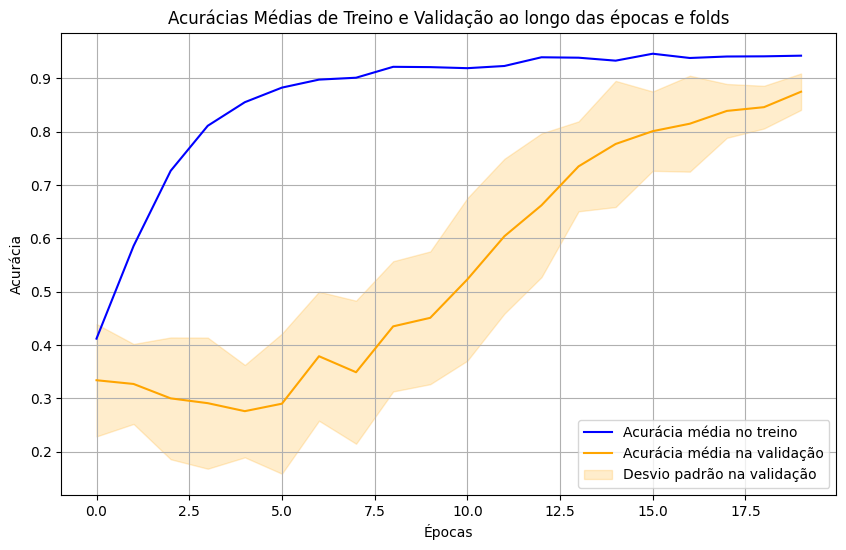

In [34]:
# Calcular a média e o desvio padrão
mean_train_accuracy = np.mean(train_accuracies, axis=0)
mean_val_accuracy = np.mean(val_accuracies, axis=0)
std_val_accuracy = np.std(val_accuracies, axis=0)

# Plotar as curvas de acurácia
plt.figure(figsize=(10, 6))
plt.plot(mean_train_accuracy, label='Acurácia média no treino', color='blue')
plt.plot(mean_val_accuracy, label='Acurácia média na validação', color='orange')
plt.fill_between(range(num_epochs),
                 mean_val_accuracy - std_val_accuracy,
                 mean_val_accuracy + std_val_accuracy,
                 color='orange', alpha=0.2, label='Desvio padrão na validação')
plt.title('Acurácias Médias de Treino e Validação ao longo das épocas e folds')
plt.xlabel('Épocas')                                                 
plt.ylabel('Acurácia')
plt.legend()
plt.grid(True)
plt.show()

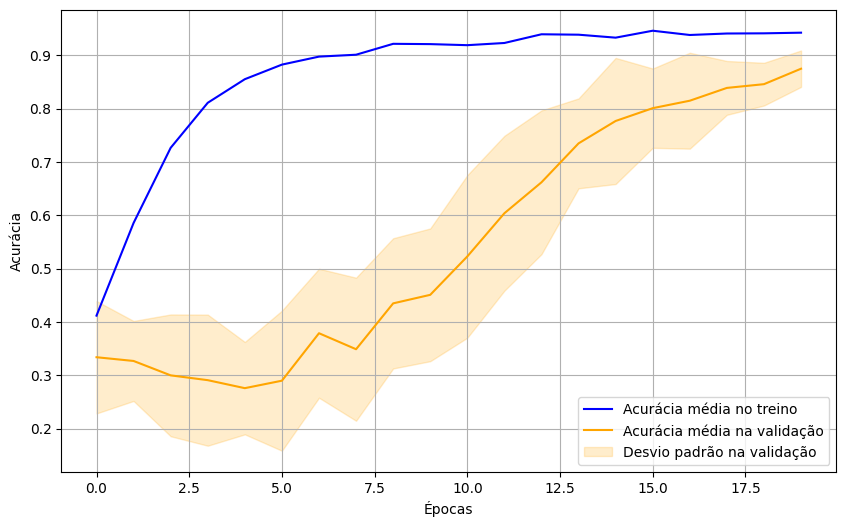

In [35]:
# Calcular a média e o desvio padrão
mean_train_accuracy = np.mean(train_accuracies, axis=0)
mean_val_accuracy = np.mean(val_accuracies, axis=0)
std_val_accuracy = np.std(val_accuracies, axis=0)

# Plotar as curvas de acurácia
plt.figure(figsize=(10, 6))
plt.plot(mean_train_accuracy, label='Acurácia média no treino', color='blue')
plt.plot(mean_val_accuracy, label='Acurácia média na validação', color='orange')
plt.fill_between(range(num_epochs),
                 mean_val_accuracy - std_val_accuracy,
                 mean_val_accuracy + std_val_accuracy,
                 color='orange', alpha=0.2, label='Desvio padrão na validação')
#plt.title('Acurácias Médias de Treino e Validação ao longo das épocas e folds')
plt.xlabel('Épocas')                                                 
plt.ylabel('Acurácia')
plt.legend()
plt.grid(True)
plt.show()

Interpretação:

A curva de training accuracy mostra como o modelo está aprendendo no conjunto de treino ao longo das épocas.
A curva de validation accuracy indica o desempenho em dados não vistos (validação).
Desvio padrão (opcional): A faixa sombreada indica a variação entre os diferentes folds, o que ajuda a avaliar a consistência.

In [36]:
def plot_training_accuracy(history, title = True):
    # Verifica se 'accuracy' está disponível no histórico
    if 'accuracy' not in history.history:
        print("Accuracy data not found in history. Check if the metric was included during compilation.")
        return
    
    # Plotar a acurácia do treino
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['accuracy'], label='Accurácia no treinamento')
    if title:
        plt.title('Acurácia no Treinamento')
    plt.xlabel('Épocas')
    plt.ylabel('Acurácia')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_training_loss(history, title = True):
    # Verifica se 'loss' está disponível no histórico
    if 'loss' not in history.history:
        print("Loss data not found in history. Check if the metric was included during compilation.")
        return
    
    # Plotar a perda do treino
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Perda no treinamento',  marker='o', color='red')
    if title:
        plt.title('Perda no Treinamento')
    plt.xlabel('Épocas')
    plt.ylabel('Perda')
    plt.legend()
    plt.grid(True)
    plt.show()


In [50]:
def plot_training_loss(history, title=True):
    # Verifica se 'loss' está disponível no histórico
    if 'loss' not in history.history:
        print("Loss data not found in history. Check if the metric was included during compilation.")
        return
    
    # Recupera os valores de perda
    losses = history.history['loss']
    
    # Plotar a perda do treino
    plt.figure(figsize=(10, 6))
    plt.plot(losses, label='Perda no treinamento', marker='o', color='firebrick')
    
    # Adicionar os valores de perda no gráfico
    for i, loss in enumerate(losses):
        plt.annotate(f"{loss:.2f}", (i, loss), textcoords="offset points", xytext=(0, 7), ha='center', fontsize=10)
    
    # Configurações do gráfico
    if title:
        plt.title('Perda no Treinamento', fontsize=16)
    plt.xlabel('Épocas', fontsize=14)
    plt.ylabel('Perda', fontsize=14)
    plt.legend(fontsize=10)
    plt.grid(alpha=0.5)
    plt.tight_layout()
    
    # Exibir o gráfico
    plt.show()


In [48]:
def plot_training_accuracy(history, title = True):
    if 'accuracy' not in history.history:
        print("Accuracy data not found in history. Check if the metric was included during compilation.")
        return

    # Plotar a acurácia do treino
    plt.figure(figsize=(10, 6))
    accuracies = history.history['accuracy']

    # Plotando a curva de acurácia
    plt.plot(accuracies, label='Acurácia no treinamento', marker='o', color='dodgerblue')

    # Adicionar valores de acurácia no gráfico
    for i, acc in enumerate(accuracies):
        plt.annotate(f"{acc:.2f}", (i, acc), textcoords="offset points", xytext=(0, 7), ha='center', fontsize=10)

    # Configurações do gráfico
    if title:
        plt.title('Acurácia no Treinamento', fontsize=16)
    plt.xlabel('Épocas', fontsize=14)
    plt.ylabel('Acurácia', fontsize=14)
    plt.legend(fontsize=10)
    plt.grid(alpha=0.4)
    plt.tight_layout()

    # Exibir o gráfico
    plt.show()


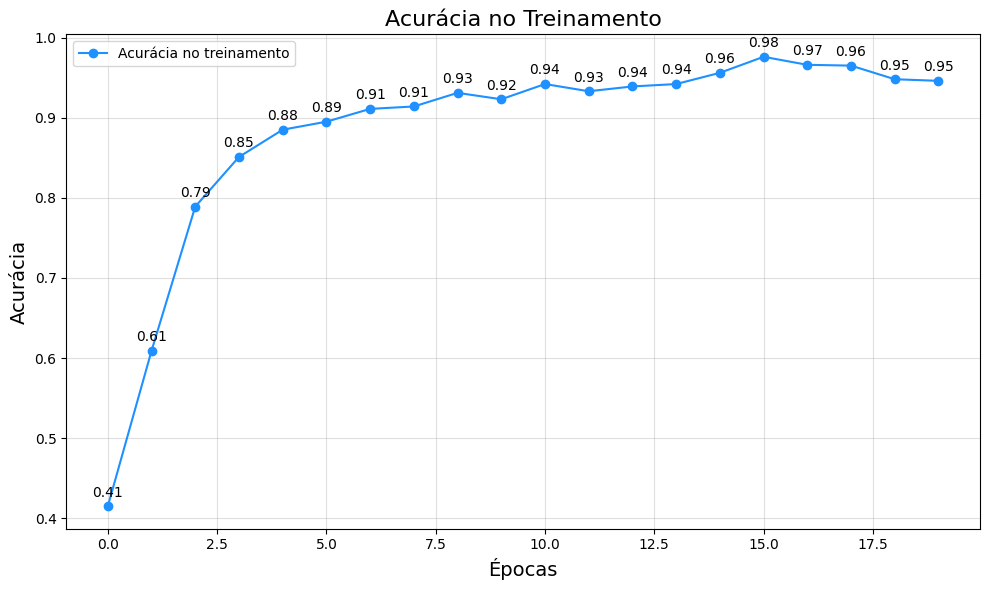

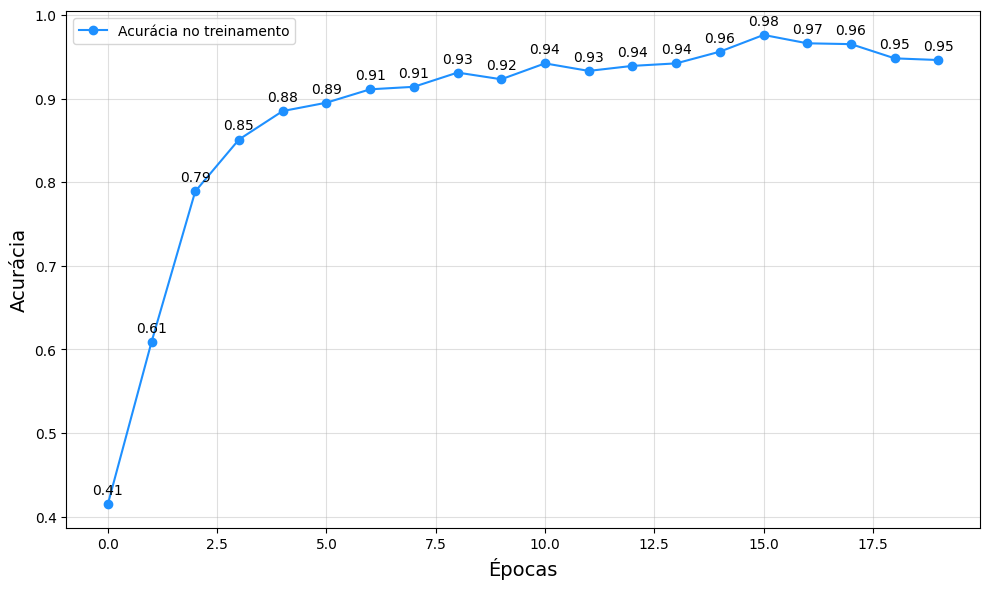

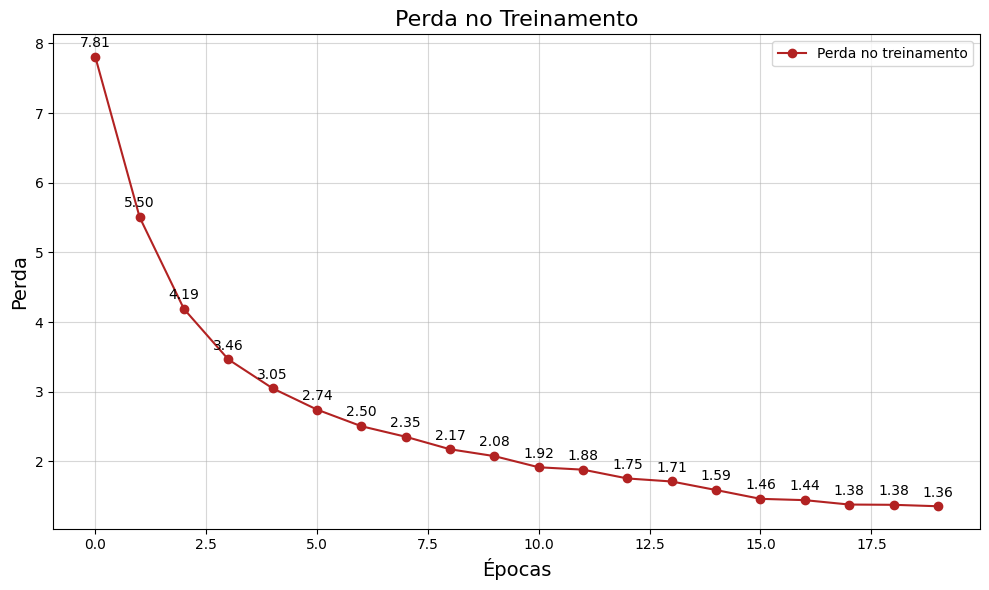

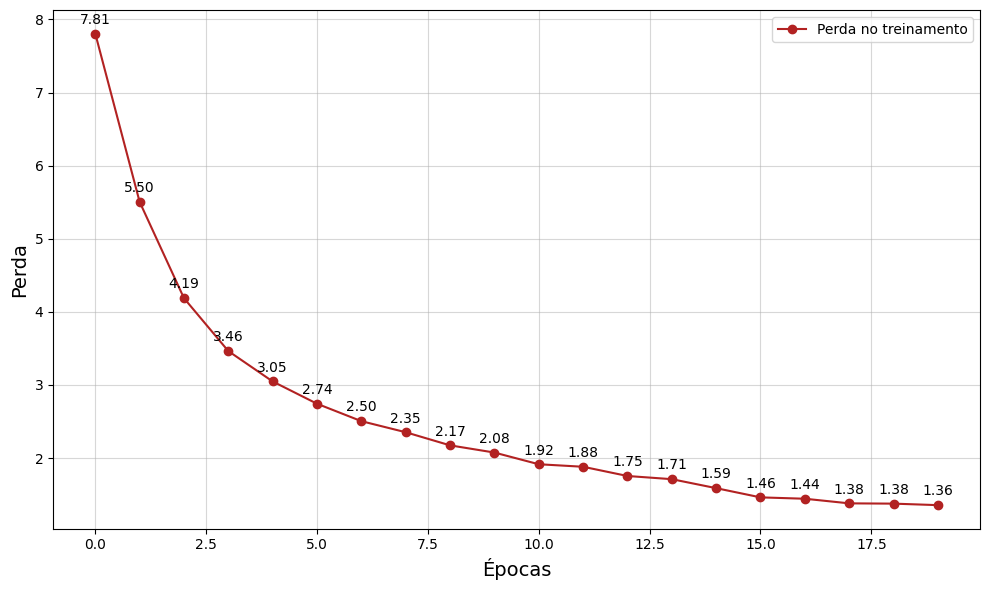

In [51]:
# Chamar a função com o histórico do treinamento final
plot_training_accuracy(history_final)
plot_training_accuracy(history_final, False)

# Chamar a função com o histórico do treinamento final
plot_training_loss(history_final)
plot_training_loss(history_final, False)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
y_pred
[[0.01626369 0.02631353 0.01194539 0.02107549 0.9244019 ]
 [0.5142177  0.0719626  0.19643952 0.13460477 0.08277542]
 [0.00296792 0.01215046 0.02355671 0.95192945 0.00939546]
 ...
 [0.01876043 0.553089   0.13314468 0.23274451 0.06226142]
 [0.00603527 0.07012174 0.8903521  0.02358145 0.00990948]
 [0.0025654  0.00358037 0.00109368 0.00238726 0.99037325]]
250
y_test
[[0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 ...
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]]
250
y_test_classes
[1 0 3 1 4 3 4 0 2 1 3 4 4 3 3 0 4 2 2 3 3 2 2 4 4 3 2 2 0 0 1 3 0 1 1 3 0
 3 2 1 2 1 3 3 4 4 2 2 0 2 1 4 0 0 4 4 0 3 4 1 1 4 1 4 4 2 1 4 3 4 0 4 0 1
 3 2 0 4 1 2 3 1 0 2 3 0 0 1 0 1 0 3 0 3 4 4 2 4 1 2 3 1 4 2 1 4 0 1 2 0 3
 1 2 2 2 0 2 0 4 2 0 1 1 2 4 1 0 4 2 0 3 3 1 1 1 1 2 2 1 2 3 3 0 3 2 0 4 4
 4 4 3 4 1 2 4 2 1 2 2 3 1 4 3 3 0 1 3 3 0 4 3 4 4 3 3 4 2 3 3 4 4 2 4 0 0
 2 4 2 4 4 2 4 1 3 3 2 3 2 1 3 1 1 1 1 2 4 1 2 3 2 1 3 2 4 1 0 3 4 1 4 1 1
 4 2 0 

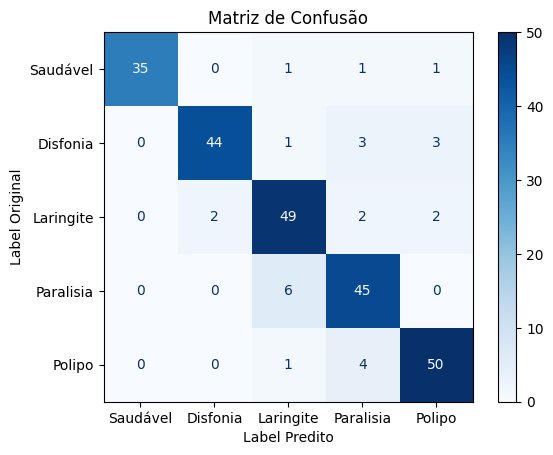

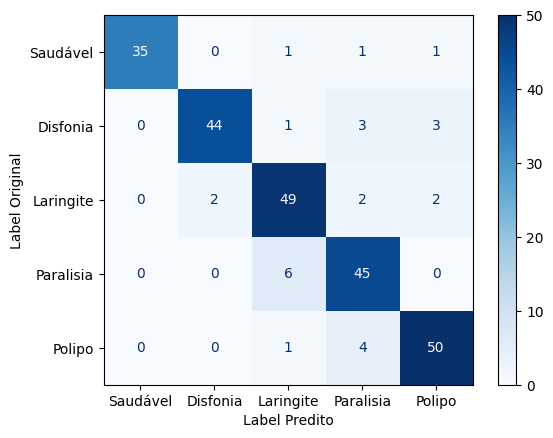

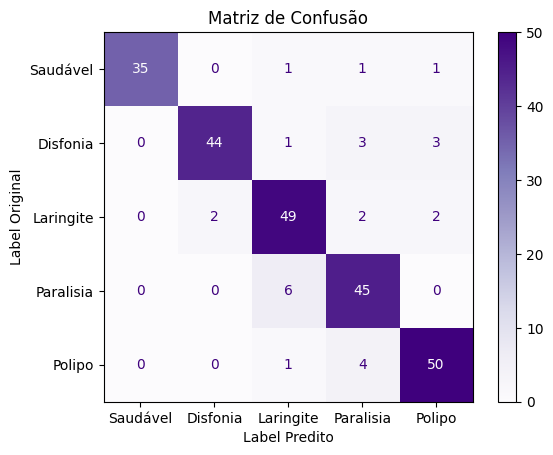

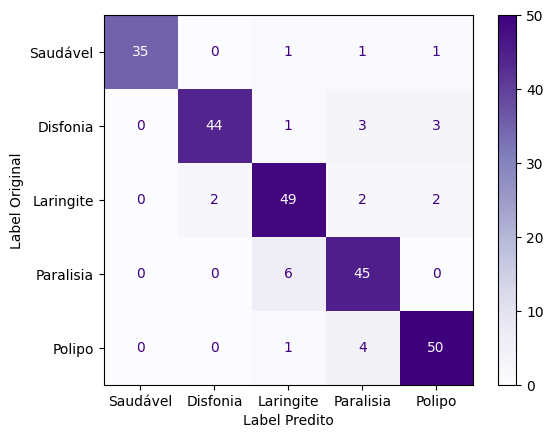

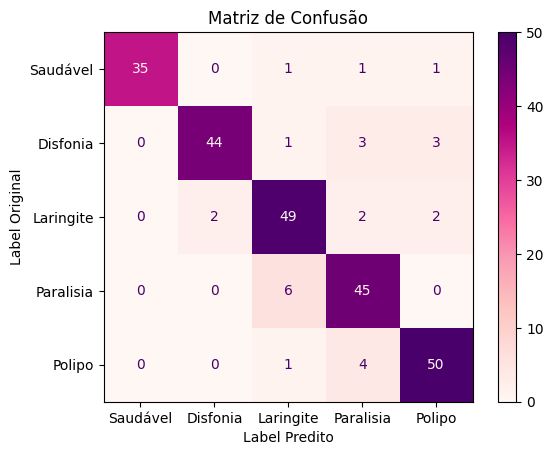

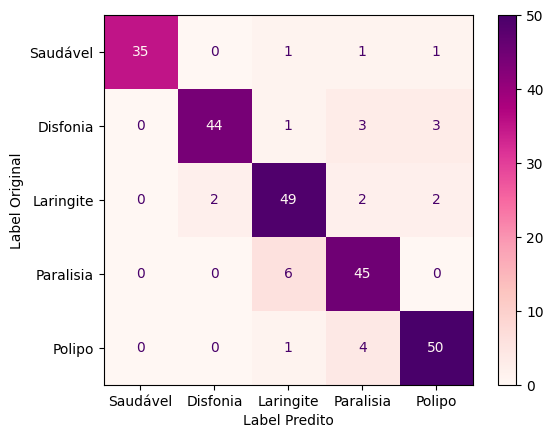

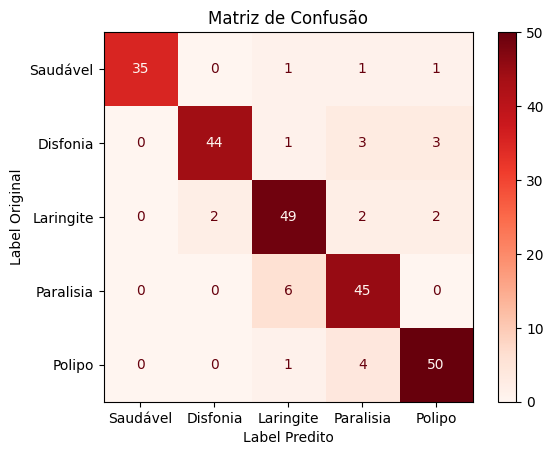

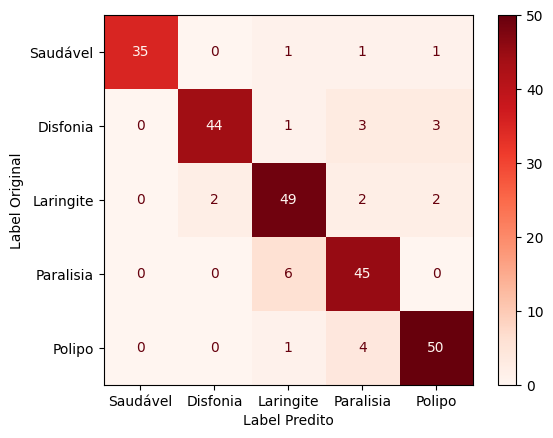

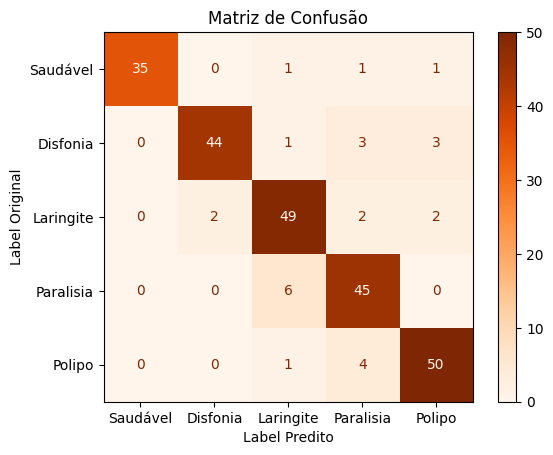

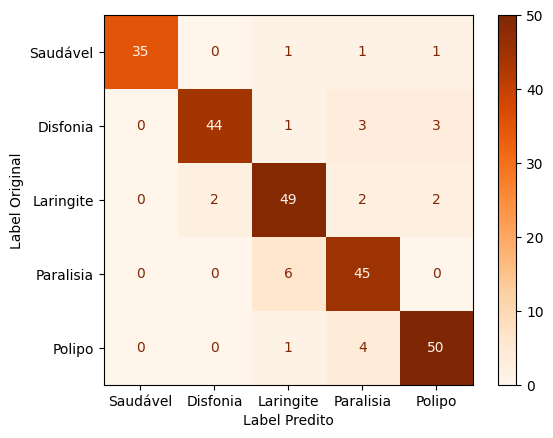

In [52]:
# Prever no conjunto de teste
y_pred = final_model.predict(X_test)
print('y_pred')
print(y_pred)
print(len(y_pred))


print('y_test')
print(y_test)
print(len(y_test))


# Converter para rótulos de classe
y_test_classes = np.argmax(y_test, axis=1)  # De one-hot para índices de classe
y_pred_classes = np.argmax(y_pred, axis=1)  # De probabilidades para índices de classe
print('y_test_classes')
print(y_test_classes)

print('y_pred_classes')
print(y_pred_classes)

# Criar matriz de confusão
cm = confusion_matrix(y_test_classes, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Saudável', 'Disfonia', 'Laringite', 'Paralisia', 'Polipo'])


# Plotar matriz
disp.plot(cmap=plt.cm.Blues)
plt.title('Matriz de Confusão')
plt.xlabel('Label Predito')
plt.ylabel('Label Original')
plt.show()

disp.plot(cmap=plt.cm.Blues)
#plt.title('Matriz de Confusão')
plt.xlabel('Label Predito')
plt.ylabel('Label Original')
plt.show()

disp.plot(cmap=plt.cm.Purples)
plt.title('Matriz de Confusão')
plt.xlabel('Label Predito')
plt.ylabel('Label Original')
plt.show()

disp.plot(cmap=plt.cm.Purples)
#plt.title('Matriz de Confusão')
plt.xlabel('Label Predito')
plt.ylabel('Label Original')
plt.show()

disp.plot(cmap=plt.cm.RdPu)
plt.title('Matriz de Confusão')
plt.xlabel('Label Predito')
plt.ylabel('Label Original')
plt.show()

disp.plot(cmap=plt.cm.RdPu)
#plt.title('Matriz de Confusão')
plt.xlabel('Label Predito')
plt.ylabel('Label Original')
plt.show()

disp.plot(cmap=plt.cm.Reds)
plt.title('Matriz de Confusão')
plt.xlabel('Label Predito')
plt.ylabel('Label Original')
plt.show()

disp.plot(cmap=plt.cm.Reds)
#plt.title('Matriz de Confusão')
plt.xlabel('Label Predito')
plt.ylabel('Label Original')
plt.show()

disp.plot(cmap=plt.cm.Oranges)
plt.title('Matriz de Confusão')
plt.xlabel('Label Predito')
plt.ylabel('Label Original')
plt.show()

disp.plot(cmap=plt.cm.Oranges)
#plt.title('Matriz de Confusão')
plt.xlabel('Label Predito')
plt.ylabel('Label Original')
plt.show()


Interpretação:

Observe o comportamento do loss durante as épocas:
Um decaimento gradual e consistente é sinal de um bom ajuste.
Se o loss oscila ou estaciona cedo, pode ser necessário ajustar hiperparâmetros (como taxa de aprendizado ou regularização).

In [53]:
def plot_roc_curve(title=True):
     from sklearn.metrics import roc_curve, auc
     from sklearn.preprocessing import label_binarize
     import matplotlib.pyplot as plt
     import numpy as np

     # Exemplo: Classes possíveis
     n_classes = y_test.shape[1]  # Assumindo que y_test está one-hot-encoded

     # Inicializar variáveis para armazenar curvas ROC e AUC
     fpr = dict()
     tpr = dict()
     roc_auc = dict()

     # Calcular ROC para cada classe individualmente
     for i in range(n_classes):
          fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])  # One-vs-Rest
          roc_auc[i] = auc(fpr[i], tpr[i])

     # Plotar a curva ROC para cada classe
     plt.figure(figsize=(10, 8))
     colors = ['blue', 'green', 'red', 'orange', 'purple', 'brown']  # Defina cores para cada classe

     for i in range(n_classes):
          if i == 0:
                    lb = 'Saudável'
          elif i == 1:
               lb = 'Disfonia'
          elif i == 2:
               lb = 'Laringite'
          elif i == 3:
               lb = 'Paralisia'
          elif i == 4:
               lb = 'Polipo'

          if 1 == 1:
               plt.plot(
                    fpr[i], tpr[i],
                    color=colors[i % len(colors)],
                    label=f'{lb} (AUC = {roc_auc[i]:.2f})'
          )

     # Adicionar linha diagonal (aleatório)
     plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Classificador aleatório')

     if title:
          plt.title('Curva ROC Multi-Classe')
     plt.xlabel('Taxa de Falsos Positivos (FPR)')
     plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
     plt.legend(loc='lower right')
     plt.grid(True)
     plt.show()


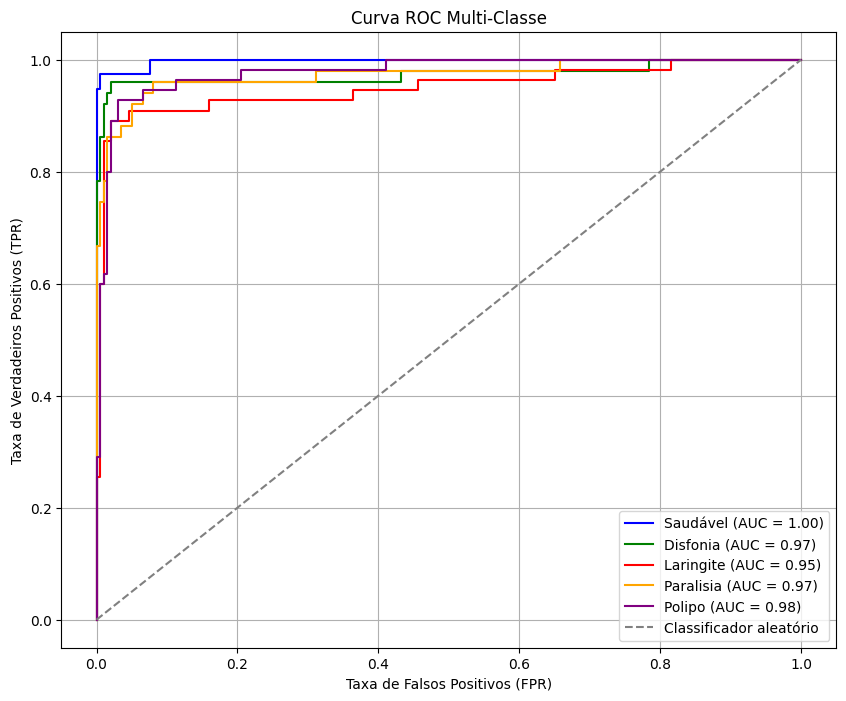

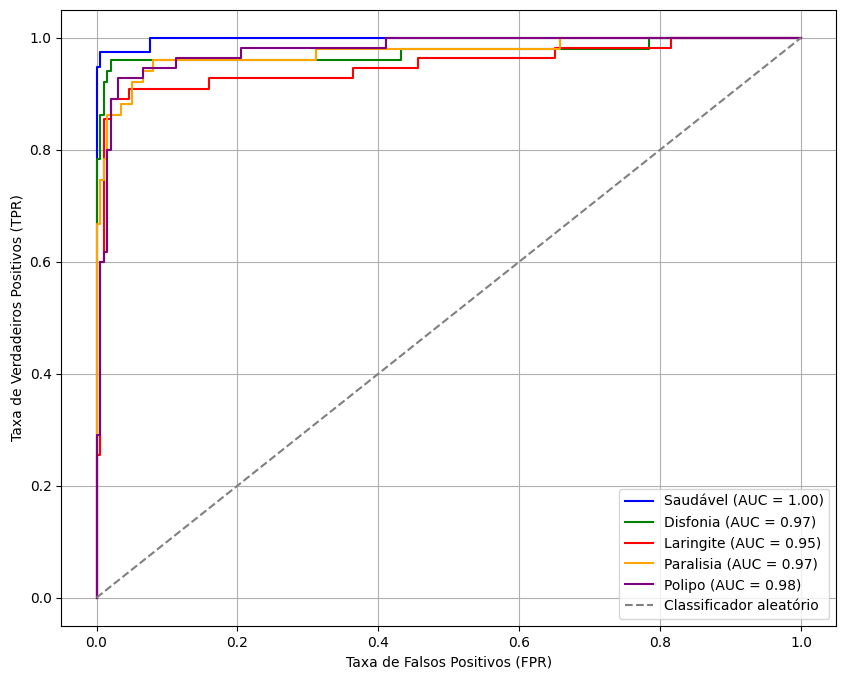

In [43]:
plot_roc_curve()
plot_roc_curve(False)

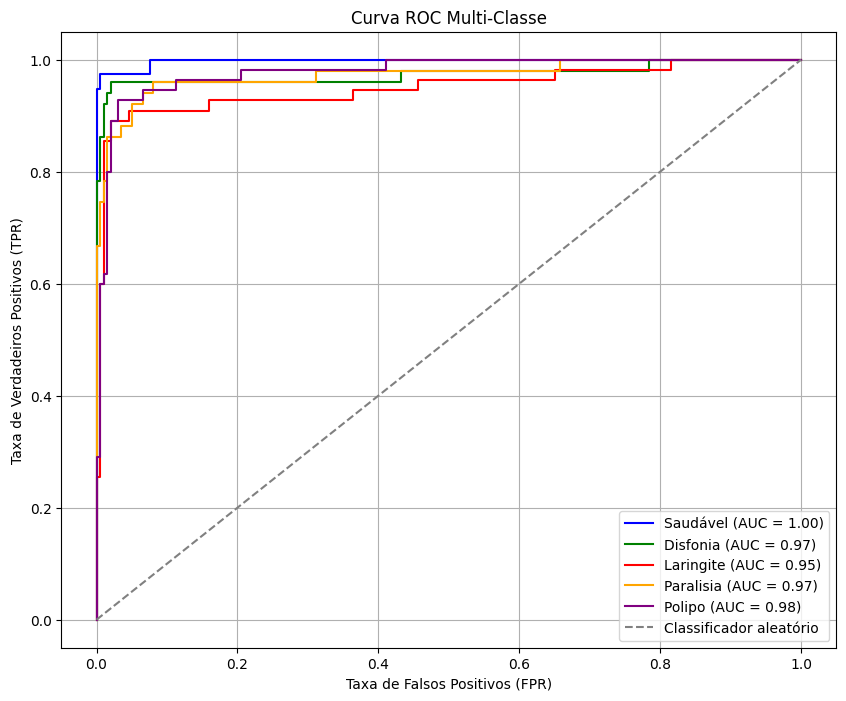

In [44]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Exemplo: Classes possíveis
n_classes = y_test.shape[1]  # Assumindo que y_test está one-hot-encoded

# Inicializar variáveis para armazenar curvas ROC e AUC
fpr = dict()
tpr = dict()
roc_auc = dict()

# Calcular ROC para cada classe individualmente
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])  # One-vs-Rest
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotar a curva ROC para cada classe
plt.figure(figsize=(10, 8))
colors = ['blue', 'green', 'red', 'orange', 'purple', 'brown']  # Defina cores para cada classe

for i in range(n_classes):
    if i == 0:
            lb = 'Saudável'
    elif i == 1:
        lb = 'Disfonia'
    elif i == 2:
        lb = 'Laringite'
    elif i == 3:
        lb = 'Paralisia'
    elif i == 4:
        lb = 'Polipo'

    if 1 == 1:
        plt.plot(
            fpr[i], tpr[i],
            color=colors[i % len(colors)],
            label=f'{lb} (AUC = {roc_auc[i]:.2f})'
    )

# Adicionar linha diagonal (aleatório)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Classificador aleatório')


plt.title('Curva ROC Multi-Classe')
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [54]:
# Média ponderada da AUC (usando frequência de cada classe)
n_classes = y_test.shape[1]
weights = np.sum(y_test, axis=0) / len(y_test)  # Frequência de cada classe
roc_auc_weighted = np.average([roc_auc[i] for i in range(n_classes)], weights=weights)
print(f"Média ponderada da AUC: {roc_auc_weighted:.2f}")


Média ponderada da AUC: 0.97


In [55]:
# Carregar o histórico salvo com pickle
with open(path_historicos_implementacao + '/' + 'model_cnn_rnn_masculino_multiclasse_history_final.pkl', 'rb') as file:
    loaded_history = pickle.load(file)

print(loaded_history)  # Dicionário com os dados do histórico


{'accuracy': [0.41499999165534973, 0.609000027179718, 0.7889999747276306, 0.8510000109672546, 0.8849999904632568, 0.8949999809265137, 0.9110000133514404, 0.9139999747276306, 0.9309999942779541, 0.9229999780654907, 0.9419999718666077, 0.9330000281333923, 0.9390000104904175, 0.9419999718666077, 0.9559999704360962, 0.9760000109672546, 0.9660000205039978, 0.9649999737739563, 0.9480000138282776, 0.9459999799728394], 'categorical_accuracy': [0.41499999165534973, 0.609000027179718, 0.7889999747276306, 0.8510000109672546, 0.8849999904632568, 0.8949999809265137, 0.9110000133514404, 0.9139999747276306, 0.9309999942779541, 0.9229999780654907, 0.9419999718666077, 0.9330000281333923, 0.9390000104904175, 0.9419999718666077, 0.9559999704360962, 0.9760000109672546, 0.9660000205039978, 0.9649999737739563, 0.9480000138282776, 0.9459999799728394], 'loss': [7.807365894317627, 5.5049028396606445, 4.187325954437256, 3.4637815952301025, 3.048051595687866, 2.7431230545043945, 2.5047006607055664, 2.35334277153

Interpretação:
Curva próxima do canto superior esquerdo: Indica alta performance.
AUC próximo de 1.0: Excelente desempenho.
AUC próximo de 0.5: Desempenho igual a um chute aleatório.

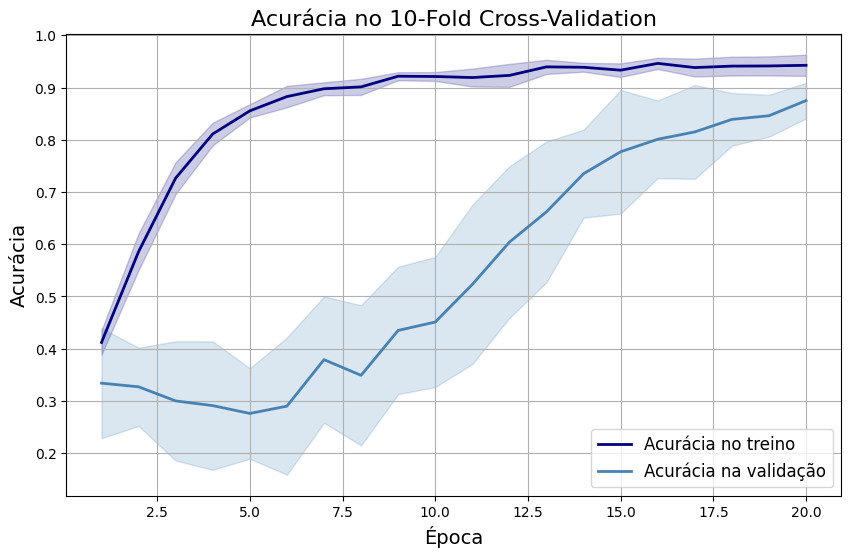

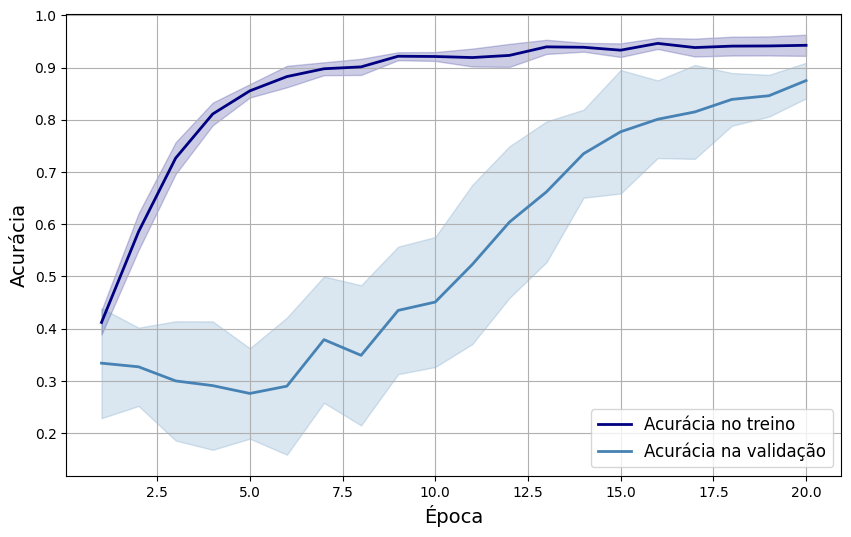

In [56]:
def plot_kfold_accuracy(histories, title=True):
    """
    Plota a curva de acurácia média para treino e validação durante o k-fold cross-validation.

    :param histories: Lista de objetos 'history' retornados por model.fit para cada fold.
    """
    # Inicializar listas para armazenar as métricas de treino e validação
    training_accuracies = []
    validation_accuracies = []

    # Iterar pelos históricos de cada fold
    for history in histories:
        training_accuracies.append(history.history['accuracy'])
        if 'val_accuracy' in history.history:
            validation_accuracies.append(history.history['val_accuracy'])

    # Calcular as médias e desvios padrão por época
    training_accuracies = np.array(training_accuracies)
    validation_accuracies = np.array(validation_accuracies)

    mean_train = np.mean(training_accuracies, axis=0)
    std_train = np.std(training_accuracies, axis=0)
    
    mean_val = np.mean(validation_accuracies, axis=0)
    std_val = np.std(validation_accuracies, axis=0)

    # Plotar as curvas de acurácia
    epochs = range(1, len(mean_train) + 1)
    plt.figure(figsize=(10, 6))
    
    # Acurácia de treino
    plt.plot(epochs, mean_train, label='Acurácia no treino', color='navy', linewidth=2)
    plt.fill_between(epochs, mean_train - std_train, mean_train + std_train, color='navy', alpha=0.2)
    
    # Acurácia de validação
    plt.plot(epochs, mean_val, label='Acurácia na validação', color='steelblue', linewidth=2)
    plt.fill_between(epochs, mean_val - std_val, mean_val + std_val, color='steelblue', alpha=0.2)
    
    # Configurações do gráfico
    if title:
        plt.title('Acurácia no 10-Fold Cross-Validation', fontsize=16)
    plt.xlabel('Época', fontsize=14)
    plt.ylabel('Acurácia', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.show()

plot_kfold_accuracy(histories)
plot_kfold_accuracy(histories, False)


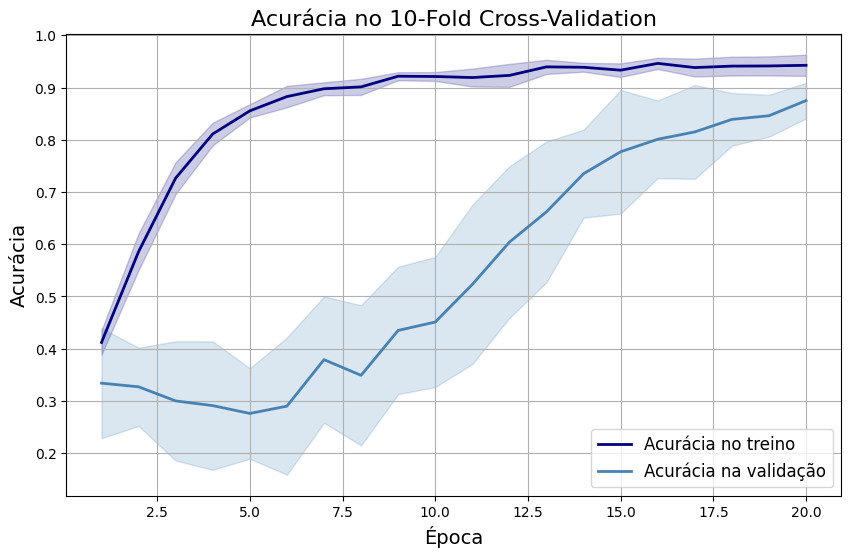

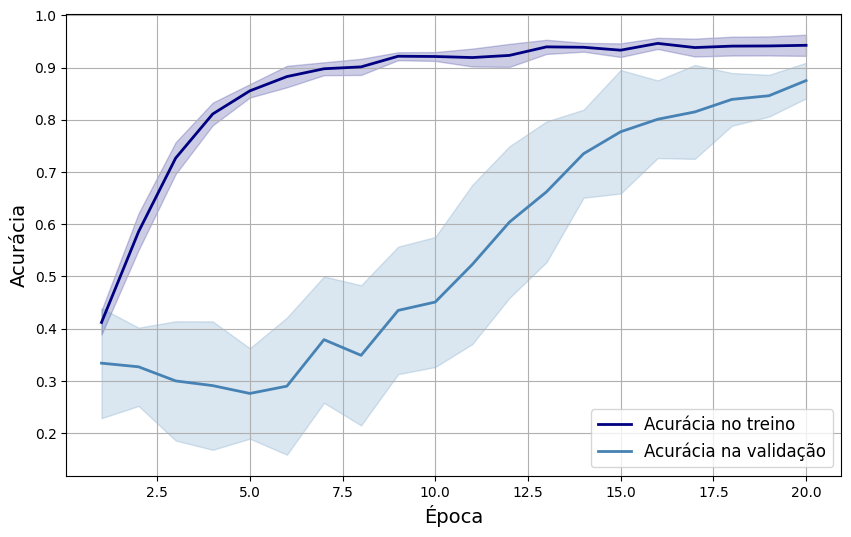

In [57]:
def plot_kfold_accuracy(histories, title=True):
    """
    Plota a curva de acurácia média para treino e validação durante o k-fold cross-validation.

    :param histories: Lista de objetos 'history' retornados por model.fit para cada fold.
    """
    # Inicializar listas para armazenar as métricas de treino e validação
    training_accuracies = []
    validation_accuracies = []

    # Iterar pelos históricos de cada fold
    for history in histories:
        training_accuracies.append(history.history['accuracy'])
        if 'val_accuracy' in history.history:
            validation_accuracies.append(history.history['val_accuracy'])

    # Calcular as médias e desvios padrão por época
    training_accuracies = np.array(training_accuracies)
    validation_accuracies = np.array(validation_accuracies)

    mean_train = np.mean(training_accuracies, axis=0)
    std_train = np.std(training_accuracies, axis=0)
    
    mean_val = np.mean(validation_accuracies, axis=0)
    std_val = np.std(validation_accuracies, axis=0)

    # Plotar as curvas de acurácia
    epochs = range(1, len(mean_train) + 1)
    plt.figure(figsize=(10, 6))
    
    # Acurácia de treino
    plt.plot(epochs, mean_train, label='Acurácia no treino', color='navy', linewidth=2)
    plt.fill_between(epochs, mean_train - std_train, mean_train + std_train, color='navy', alpha=0.2)
    
    # Acurácia de validação
    plt.plot(epochs, mean_val, label='Acurácia na validação', color='steelblue', linewidth=2)
    plt.fill_between(epochs, mean_val - std_val, mean_val + std_val, color='steelblue', alpha=0.2)
    
    # Configurações do gráfico
    if title:
        plt.title('Acurácia no 10-Fold Cross-Validation', fontsize=16)
    plt.xlabel('Época', fontsize=14)
    plt.ylabel('Acurácia', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.show()

plot_kfold_accuracy(histories)
plot_kfold_accuracy(histories, False)
